In [74]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("ff_cp.db")
df = pd.read_sql_query("SELECT * from timepoint", con)

# Verify that result of SQL query is stored in the dataframe
print(df.head())

con.close()

   id id_club     timestamp  checkins  total_allowed
0   1     209  1.672683e+09        81            110
1   2      95  1.672683e+09        99            150
2   3     115  1.672683e+09       189            280
3   4     111  1.672683e+09       400            470
4   5     207  1.672683e+09        92            130


In [290]:
weekday_colors = ['blue', 'green', 'black', 'yellow', 'pink', 'red', 'orange']
weekdays_sorted = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [260]:
def get_minute_of_day(time):
    minutes = 0
    minutes += time.hour*60
    minutes += time.minute
    return minutes

wiesbaden_timepoints = df[df.id_club == "99"]
wiesbaden_timepoints['percentage'] = wiesbaden_timepoints['checkins'] / wiesbaden_timepoints['total_allowed'] * 100.
wiesbaden_timepoints['datetime'] = pd.to_datetime(wiesbaden_timepoints.timestamp * 1e9)
wiesbaden_timepoints['weekday'] = wiesbaden_timepoints['datetime'].dt.dayofweek
wiesbaden_timepoints['minute_of_day'] = wiesbaden_timepoints.apply(lambda x: get_minute_of_day(x['datetime'].time()), axis=1)
wiesbaden_timepoints

/tmp/ipykernel_74761/3774457166.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiesbaden_timepoints['percentage'] = wiesbaden_timepoints['checkins'] / wiesbaden_timepoints['total_allowed'] * 100.
/tmp/ipykernel_74761/3774457166.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiesbaden_timepoints['datetime'] = pd.to_datetime(wiesbaden_timepoints.timestamp * 1e9)
/tmp/ipykernel_74761/3774457166.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,id,id_club,timestamp,checkins,total_allowed,percentage,datetime,weekday,minute_of_day
78,79,99,1.672683e+09,186,230,80.869565,2023-01-02 18:18:06.488485376,0,1098
131,132,99,1.672684e+09,182,230,79.130435,2023-01-02 18:22:08.776458496,0,1102
182,183,99,1.672684e+09,185,230,80.434783,2023-01-02 18:23:06.614493184,0,1103
233,234,99,1.672684e+09,182,230,79.130435,2023-01-02 18:24:06.642478592,0,1104
288,289,99,1.672684e+09,180,230,78.260870,2023-01-02 18:25:07.396379136,0,1105
...,...,...,...,...,...,...,...,...,...
3520014,3520015,99,1.682848e+09,117,368,31.793478,2023-04-30 09:49:07.048345600,6,589
3520061,3520062,99,1.682848e+09,117,368,31.793478,2023-04-30 09:50:06.592706048,6,590
3520117,3520118,99,1.682848e+09,117,368,31.793478,2023-04-30 09:51:07.375601408,6,591
3520165,3520166,99,1.682848e+09,117,368,31.793478,2023-04-30 09:52:06.652657408,6,592


In [223]:
len(wiesbaden_timepoints.checkins) #.plot()

68394

In [261]:
# divide into chunks of days
results = [group[1] for group in wiesbaden_timepoints.groupby(wiesbaden_timepoints.datetime.dt.date)]

In [262]:
# we should have 24*60=1440 results if the complete day was captured
# we NEVER got the full 1440 datapoints?!
# lets use a bit less
full_results = []
for r in results:
    if len(r) >= 1300:
        full_results.append(r)
print(f"Got {len(full_results)} \"full\" days")

Got 42 "full" days


In [263]:
# interpolate missing values to have full 1440-item-arrays
new_full_results = []
for fr in full_results:
    all_minutes_of_day = list(range(1441))
    minutes_in_dataframe = list(fr.minute_of_day)
    
    missing_minutes = []
    for amod in all_minutes_of_day:
        if amod not in minutes_in_dataframe:
            missing_minutes.append(amod)
            
    # interpolate missing minutes
    for mm in missing_minutes:
        print(f"Computing minute {mm}")
        if mm > 0:
            value_before = fr[fr.minute_of_day == mm-1].percentage.iloc[0]
        
        if mm < 1440:
            for i in range(1,1440-mm):
                if not fr[fr.minute_of_day == mm+i].empty:
                    print(f"--> using value of {(mm+i)}")
                    value_after = fr[fr.minute_of_day == mm+i].percentage.iloc[0]
                    break
        else:
            value_after = value_before
            
        if mm == 0:
            value_bevore = value_after
            
        print(f"\tValue before: {value_before}, value after: {value_after}")
        interp_value = (value_after + value_before)/2

        my_new_row = fr.iloc[0]
        my_new_row.minute_of_day = mm
        my_new_row.percentage = interp_value
        my_new_row.id = None
        
        fr = fr.append(my_new_row, ignore_index=True)
        
    fr.sort_values(by='minute_of_day', inplace=True)
    new_full_results.append(fr)
    print(f"Missing minutes of day: {missing_minutes}")
    
full_results = new_full_results
print()    
    
for fr in full_results:
    all_minutes_of_day = list(range(1441))
    minutes_in_dataframe = list(fr.minute_of_day)
    
    missing_minutes = []
    for amod in all_minutes_of_day:
        if amod not in minutes_in_dataframe:
            missing_minutes.append(amod)

    for mm in missing_minutes:
        print("Still missing ",mm)

Computing minute 813
--> using value of 814
	Value before: 39.565217391304344, value after: 39.565217391304344
Computing minute 1323
--> using value of 1324
	Value before: 17.82608695652174, value after: 16.52173913043478
Computing minute 1327
--> using value of 1328
	Value before: 16.52173913043478, value after: 0.0
Computing minute 1440
	Value before: 0.0, value after: 0.0
Missing minutes of day: [813, 1323, 1327, 1440]
Computing minute 331
--> using value of 332
	Value before: 0.0, value after: 0.0
Computing minute 1321
--> using value of 1326
	Value before: 10.434782608695652, value after: 10.434782608695652
Computing minute 1322
--> using value of 1326
	Value before: 10.434782608695652, value after: 10.434782608695652
Computing minute 1323
--> using value of 1326
	Value before: 10.434782608695652, value after: 10.434782608695652
Computing minute 1324
--> using value of 1326
	Value before: 10.434782608695652, value after: 10.434782608695652
Computing minute 1325
--> using value of 

/usr/local/lib/python3.10/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 162
--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 163
--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 164
--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 165
--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 166
--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 167
--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 168
--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 169
--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 170
--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 171
--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 172
--> using value of 190
	Value before: 0.0, value after: 0.0
Computing minute 173
--> using value of 190
	Valu

--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 196
--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 197
--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 198
--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 199
--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 200
--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 201
--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 202
--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 203
--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 204
--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 205
--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 206
--> using value of 216
	Value before: 0.0, value after: 0.0
Computing minute 207
--> using value of 216
	Valu

--> using value of 938
	Value before: 20.652173913043477, value after: 21.467391304347828
Computing minute 937
--> using value of 938
	Value before: 21.059782608695652, value after: 21.467391304347828
Computing minute 939
--> using value of 941
	Value before: 21.467391304347828, value after: 21.73913043478261
Computing minute 940
--> using value of 941
	Value before: 21.60326086956522, value after: 21.73913043478261
Computing minute 1251
--> using value of 1252
	Value before: 22.554347826086957, value after: 22.282608695652172
Computing minute 1440
	Value before: 0.0, value after: 0.0
Missing minutes of day: [632, 633, 634, 746, 747, 749, 751, 936, 937, 939, 940, 1251, 1440]
Computing minute 411
--> using value of 414
	Value before: 7.608695652173914, value after: 7.608695652173914
Computing minute 412
--> using value of 414
	Value before: 7.608695652173914, value after: 7.608695652173914
Computing minute 413
--> using value of 414
	Value before: 7.608695652173914, value after: 7.60869

Computing minute 68
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 69
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 70
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 71
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 72
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 73
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 74
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 75
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 76
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 77
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 78
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 79
--> using value of 122
	Value before: 0.0, value after: 0.0
Computing minute 80
--> using value of 1

Missing minutes of day: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 250, 251, 252, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 284, 299, 300, 301, 313, 314, 315, 316, 317, 318, 319, 322, 323, 324, 326, 327, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 344, 399, 400, 402, 404, 733, 734, 736, 865, 966, 1071, 1072, 1074, 1097, 1440]
Computing minute 344
--> using value of 347
	Value before: 4.076086956521739, value after: 4.619565217391304
Computing minute 345
--> using value of 347
	Value before: 4.3478260869565215, value after: 4.619565217391304
Computing minute 346
--> using value of 347
	Value before: 4.483695652173912, value after: 4.619565217391304
Computing minute 576
--> us

--> using value of 476
	Value before: 15.217391304347828, value after: 15.217391304347828
Computing minute 517
--> using value of 520
	Value before: 18.206521739130434, value after: 18.206521739130434
Computing minute 518
--> using value of 520
	Value before: 18.206521739130434, value after: 18.206521739130434
Computing minute 519
--> using value of 520
	Value before: 18.206521739130434, value after: 18.206521739130434
Computing minute 795
--> using value of 797
	Value before: 20.652173913043477, value after: 20.652173913043477
Computing minute 796
--> using value of 797
	Value before: 20.652173913043477, value after: 20.652173913043477
Computing minute 942
--> using value of 944
	Value before: 29.6195652173913, value after: 29.6195652173913
Computing minute 943
--> using value of 944
	Value before: 29.6195652173913, value after: 29.6195652173913
Computing minute 947
--> using value of 948
	Value before: 30.706521739130434, value after: 31.793478260869566
Computing minute 1440
	Value b

Computing minute 56
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 57
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 58
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 59
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 60
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 61
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 62
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 63
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 64
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 65
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 66
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 67
--> using value of 107
	Value before: 0.0, value after: 0.0
Computing minute 68
--> using value of 1

Computing minute 1317
--> using value of 1319
	Value before: 0.2717391304347826, value after: 0.2717391304347826
Computing minute 1318
--> using value of 1319
	Value before: 0.2717391304347826, value after: 0.2717391304347826
Computing minute 1326
--> using value of 1327
	Value before: 0.2717391304347826, value after: 0.2717391304347826
Computing minute 1440
	Value before: 0.2717391304347826, value after: 0.2717391304347826
Missing minutes of day: [61, 547, 551, 609, 903, 904, 1317, 1318, 1326, 1440]
Computing minute 360
--> using value of 363
	Value before: 11.141304347826086, value after: 11.141304347826086
Computing minute 361
--> using value of 363
	Value before: 11.141304347826086, value after: 11.141304347826086
Computing minute 362
--> using value of 363
	Value before: 11.141304347826086, value after: 11.141304347826086
Computing minute 364
--> using value of 366
	Value before: 11.141304347826086, value after: 11.41304347826087
Computing minute 365
--> using value of 366
	Value 

--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 58
--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 59
--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 60
--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 61
--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 62
--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 63
--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 64
--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 65
--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 66
--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 67
--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 68
--> using value of 104
	Value before: 0.0, value after: 0.0
Computing minute 69
--> using value of 104
	Value before: 0.

Computing minute 914
--> using value of 915
	Value before: 31.793478260869566, value after: 31.793478260869566
Computing minute 916
--> using value of 917
	Value before: 31.793478260869566, value after: 33.15217391304348
Computing minute 918
--> using value of 919
	Value before: 33.15217391304348, value after: 33.96739130434783
Computing minute 1168
--> using value of 1170
	Value before: 33.69565217391305, value after: 32.33695652173913
Computing minute 1169
--> using value of 1170
	Value before: 33.01630434782609, value after: 32.33695652173913
Computing minute 1379
--> using value of 1381
	Value before: 0.0, value after: 0.0
Computing minute 1380
--> using value of 1381
	Value before: 0.0, value after: 0.0
Computing minute 1384
--> using value of 1385
	Value before: 0.0, value after: 0.0
Computing minute 1440
	Value before: 0.0, value after: 0.0
Missing minutes of day: [351, 353, 564, 565, 685, 686, 689, 784, 785, 912, 913, 914, 916, 918, 1168, 1169, 1379, 1380, 1384, 1440]
Computing

Computing minute 47
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 48
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 49
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 50
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 51
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 52
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 53
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 54
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 55
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 56
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 57
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 58
--> using value of 112
	Value before: 0.0, value after: 0.0
Computing minute 59
--> using value of 1

Computing minute 495
--> using value of 496
	Value before: 19.021739130434785, value after: 19.021739130434785
Computing minute 568
--> using value of 570
	Value before: 26.6304347826087, value after: 28.26086956521739
Computing minute 569
--> using value of 570
	Value before: 27.445652173913047, value after: 28.26086956521739
Computing minute 572
--> using value of 573
	Value before: 28.26086956521739, value after: 28.26086956521739
Computing minute 646
--> using value of 647
	Value before: 23.641304347826086, value after: 23.641304347826086
Computing minute 762
--> using value of 763
	Value before: 21.73913043478261, value after: 21.73913043478261
Computing minute 766
--> using value of 767
	Value before: 21.73913043478261, value after: 20.92391304347826
Computing minute 856
--> using value of 858
	Value before: 19.83695652173913, value after: 19.565217391304348
Computing minute 857
--> using value of 858
	Value before: 19.70108695652174, value after: 19.565217391304348
Computing min

In [293]:
weekday_arrays = {}
for r in full_results:
    dayname = r.iloc[0].datetime.day_name()
    if dayname not in weekday_arrays.keys():
        weekday_arrays[dayname] = []
          
    weekday_arrays[dayname].append(np.array([r.minute_of_day, r.percentage]))

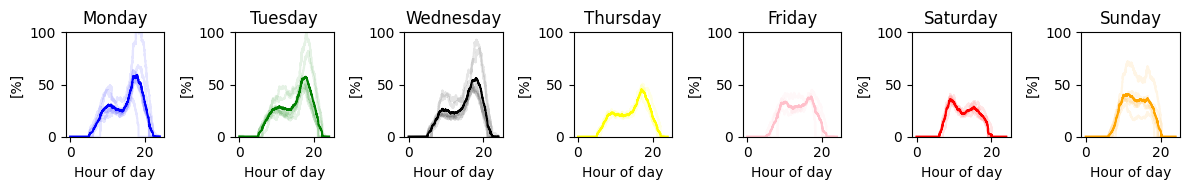

In [303]:
fig = plt.figure(figsize=(12,2))
for idx,wds in enumerate(weekdays_sorted):
    dayname = wds
    dayarrays = weekday_arrays[wds]
    fig.add_subplot(1,7,idx+1)
    plt.title(dayname)
    
    for da in dayarrays:
        plt.plot(da[0,:]/60, da[1,:], c=weekday_colors[idx], alpha=0.1)
    
    dayarrays = np.array(dayarrays)
    plt.plot(dayarrays[0][0]/60, np.mean(dayarrays[:,1], axis=0), c=weekday_colors[idx], label=dayname)
    plt.ylim((0,100))
    plt.xlabel('Hour of day')
    plt.ylabel('[%]')
plt.tight_layout()
plt.show()

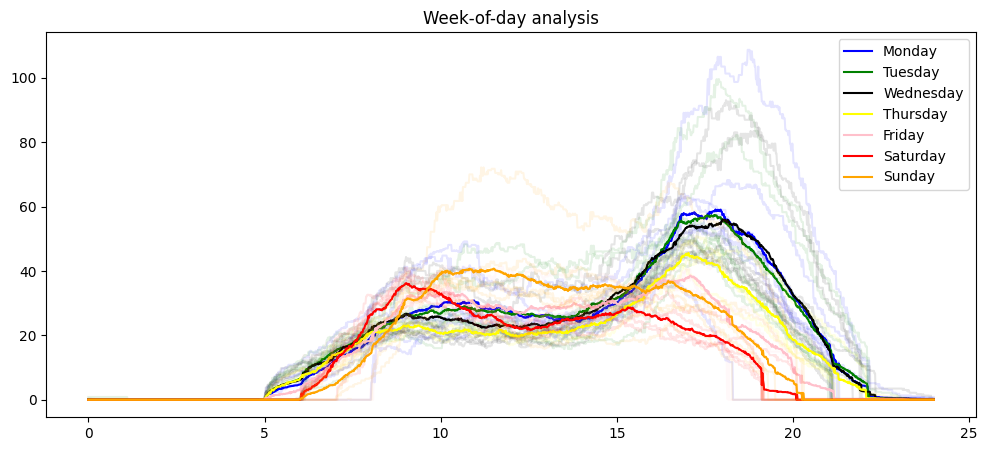

In [304]:
# all weekdays in one plot
fig = plt.figure(figsize=(12,5))
plt.title("Week-of-day analysis")

for idx,wds in enumerate(weekdays_sorted):
    dayname = wds
    dayarrays = weekday_arrays[wds]
    
    for da in dayarrays:
        plt.plot(da[0,:]/60, da[1,:], c=weekday_colors[idx], alpha=0.1)
    
    dayarrays = np.array(dayarrays)
    plt.plot(dayarrays[0][0]/60, np.mean(dayarrays[:,1], axis=0), c=weekday_colors[idx], label=dayname)
    
plt.legend()
plt.show()

In [305]:
# best timepoints for each day to go training:
for idx,wds in enumerate(weekdays_sorted):
    dayname = wds
    dayarrays = weekday_arrays[wds]
    dayarrays = np.array(dayarrays)
    
    means_for_that_day = np.mean(dayarrays[:,1], axis=0)
    
    start_time_minute_of_day = 10*60
    end_time_minute_of_day = 15*60
    min_val = np.min(means_for_that_day[start_time_minute_of_day:end_time_minute_of_day])
        
    print(f"{wds}: {round(np.where(means_for_that_day == min_val)[0][0]/60)}")

Monday: 14
Tuesday: 14
Wednesday: 12
Thursday: 12
Friday: 12
Saturday: 13
Sunday: 14


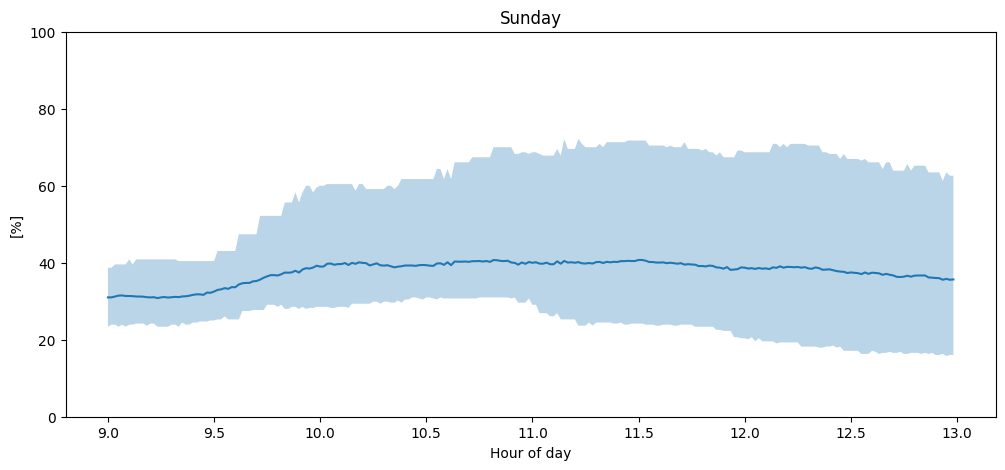

Anticipating Sunday after 9
9: 21.8% (12.2% - 29.1%)
10: 33.6% (25.7% - 45.6%)
11: 39.8% (30.1% - 63.5%)
12: 39.8% (24.2% - 69.8%)
13: 37.5% (17.7% - 67.1%)


In [336]:
# given a day and a time, estimate the next few hours
day_to_check = 'Sunday'
hour_to_check = 9
minute_of_day_to_check = hour_to_check * 60
hours_into_the_future = 4

# get the arrays for this day
dayarrays = weekday_arrays[day_to_check]
dayarrays = np.array(dayarrays)

# calculate a min/max for the next 3 hours
means_for_that_day = np.mean(dayarrays[:,1], axis=0)
mins_for_that_day = np.min(dayarrays[:,1], axis=0)
maxs_for_that_day = np.max(dayarrays[:,1], axis=0)

# make a pretty plot
fig = plt.figure(figsize=(12,5))
plt.title(day_to_check)
mint = minute_of_day_to_check
maxt = minute_of_day_to_check + hours_into_the_future*60
plt.plot(np.array(range(mint,maxt))/60, means_for_that_day[mint:maxt])
plt.fill_between(np.array(range(mint,maxt))/60, mins_for_that_day[mint:maxt], maxs_for_that_day[mint:maxt], alpha=0.3)
plt.xlabel("Hour of day")
plt.ylabel('[%]')
plt.ylim((0,100))
plt.show()

print(f"Anticipating {day_to_check} after {round(minute_of_day_to_check/60)}")

for next_hour in range(hours_into_the_future+1):
    if hour_to_check + next_hour < 24:
        hour_values = means_for_that_day[minute_of_day_to_check+(next_hour-1)*60:
                                     minute_of_day_to_check+(next_hour)*60
                                    ]
        hour_values_min = mins_for_that_day[minute_of_day_to_check+(next_hour-1)*60:
                                     minute_of_day_to_check+(next_hour)*60
                                    ]
        hour_values_max = maxs_for_that_day[minute_of_day_to_check+(next_hour-1)*60:
                                     minute_of_day_to_check+(next_hour)*60
                                    ]
        print(f"{hour_to_check+next_hour}: {np.mean(hour_values):.1f}% ({np.mean(hour_values_min):.1f}% - {np.mean(hour_values_max):.1f}%)")